Rows: 2163 | Features: 18
X: (2126, 30, 18) y: (2126,)
Train: (850, 30, 18) Test: (1276, 30, 18)
Epoch 1/70 | Loss: 0.006347
Epoch 2/70 | Loss: 0.001427
Epoch 3/70 | Loss: 0.001091
Epoch 4/70 | Loss: 0.001046
Epoch 5/70 | Loss: 0.001022
Epoch 6/70 | Loss: 0.001004
Epoch 7/70 | Loss: 0.000988
Epoch 8/70 | Loss: 0.000975
Epoch 9/70 | Loss: 0.000964
Epoch 10/70 | Loss: 0.000953
Epoch 11/70 | Loss: 0.000944
Epoch 12/70 | Loss: 0.000935
Epoch 13/70 | Loss: 0.000927
Epoch 14/70 | Loss: 0.000920
Epoch 15/70 | Loss: 0.000913
Epoch 16/70 | Loss: 0.000906
Epoch 17/70 | Loss: 0.000900
Epoch 18/70 | Loss: 0.000894
Epoch 19/70 | Loss: 0.000889
Epoch 20/70 | Loss: 0.000884
Epoch 21/70 | Loss: 0.000879
Epoch 22/70 | Loss: 0.000874
Epoch 23/70 | Loss: 0.000869
Epoch 24/70 | Loss: 0.000865
Epoch 25/70 | Loss: 0.000861
Epoch 26/70 | Loss: 0.000857
Epoch 27/70 | Loss: 0.000853
Epoch 28/70 | Loss: 0.000850
Epoch 29/70 | Loss: 0.000847
Epoch 30/70 | Loss: 0.000844
Epoch 31/70 | Loss: 0.000841
Epoch 32/70 |

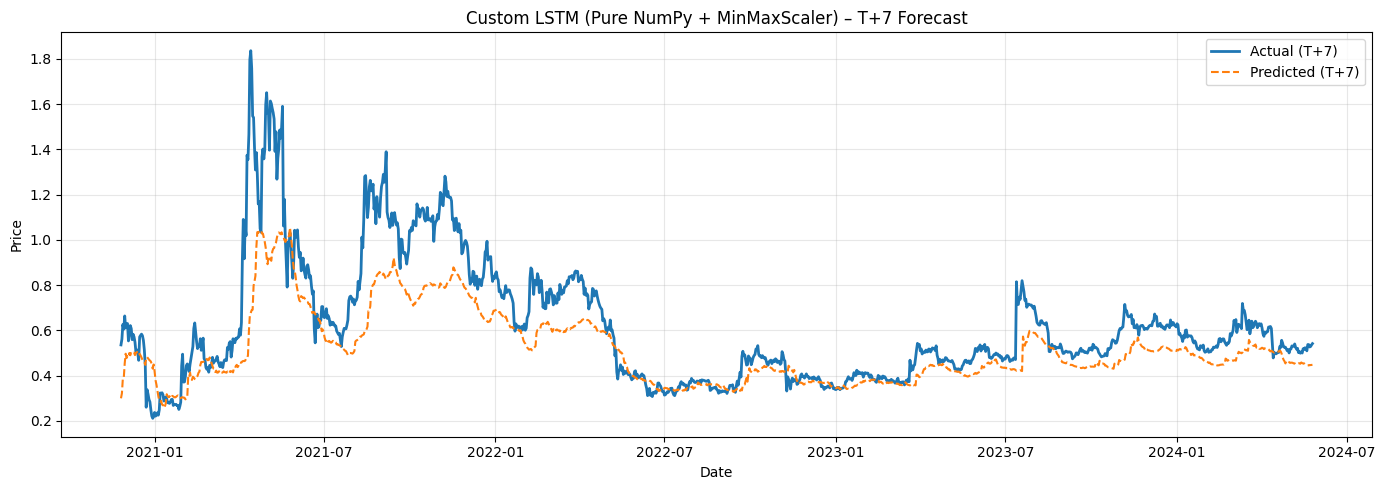

In [9]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# ======================================================
# 1. LOAD DATA
# ======================================================
df = pd.read_csv("data2.csv")   # Date, Price, High, Low, Vol
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values("Date").reset_index(drop=True)

EPS = 1e-8

# ======================================================
# 2. FEATURE ENGINEERING
# ======================================================
df['VVR'] = df['Vol'] / (df['High'] - df['Low'] + EPS)
df['VWAP'] = (
    ((df['High'] + df['Low'] + df['Price']) / 3 * df['Vol']).cumsum()
    / df['Vol'].cumsum()
)

for lag in [1, 2, 3, 5, 7]:
    df[f'Lag_{lag}'] = df['Price'].shift(lag)

df['Change'] = df['Price'].pct_change()
df['Volatility'] = df['High'] - df['Low']
df['MA5'] = df['Price'].rolling(5).mean()
df['MA15'] = df['Price'].rolling(15).mean()
df['MA30'] = df['Price'].rolling(30).mean()

# ===== REGIME FEATURE =====
df['vol_z'] = (
    df['Volatility'] - df['Volatility'].rolling(30).mean()
) / (df['Volatility'].rolling(30).std() + EPS)

df['is_spike'] = (df['vol_z'] > 2).astype(int)

df = df.dropna().reset_index(drop=True)

print(f"Rows: {len(df)} | Features: {df.shape[1]-2}")

# ======================================================
# 3. SCALE DATA (MIN-MAX)
# ======================================================
feature_cols = [c for c in df.columns if c not in ['Date', 'Price']]

X_raw = df[feature_cols].values
y_raw = df['Price'].values.reshape(-1, 1)

scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

X_scaled = scaler_X.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw).ravel()

dates = df['Date'].values

# ======================================================
# 4. BUILD SEQUENCES (30 DAYS → T+7)
# ======================================================
LOOKBACK = 30
HORIZON = 7

X_seq, y_seq, y_dates = [], [], []

for i in range(len(X_scaled) - LOOKBACK - HORIZON):
    X_seq.append(X_scaled[i:i + LOOKBACK])
    y_seq.append(y_scaled[i + LOOKBACK + HORIZON - 1])
    y_dates.append(dates[i + LOOKBACK + HORIZON - 1])

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)
y_dates = np.array(y_dates)

print("X:", X_seq.shape, "y:", y_seq.shape)

# ======================================================
# 5. TRAIN / TEST SPLIT (TIME-AWARE)
# ======================================================
split = int(len(X_seq) * 0.4)

X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]
date_train, date_test = y_dates[:split], y_dates[split:]

print("Train:", X_train.shape, "Test:", X_test.shape)

# ======================================================
# 6. ACTIVATION FUNCTIONS
# ======================================================
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def dsigmoid(y):
    return y * (1 - y)

def dtanh(y):
    return 1 - y ** 2

# ======================================================
# 7. CUSTOM LSTM CELL (FULL BPTT)
# ======================================================
class CustomLSTM:
    def __init__(self, input_dim, hidden_dim):
        self.hidden_dim = hidden_dim

        self.Wf = np.random.randn(input_dim + hidden_dim, hidden_dim) * 0.1
        self.Wi = np.random.randn(input_dim + hidden_dim, hidden_dim) * 0.1
        self.Wc = np.random.randn(input_dim + hidden_dim, hidden_dim) * 0.1
        self.Wo = np.random.randn(input_dim + hidden_dim, hidden_dim) * 0.1

        self.Wy = np.random.randn(hidden_dim, 1) * 0.1

    def forward(self, X):
        h = np.zeros(self.hidden_dim)
        c = np.zeros(self.hidden_dim)
        self.cache = []

        for x in X:
            z = np.concatenate([h, x])

            f = sigmoid(z @ self.Wf)
            i = sigmoid(z @ self.Wi)
            c_hat = np.tanh(z @ self.Wc)
            o = sigmoid(z @ self.Wo)

            c = f * c + i * c_hat
            h = o * np.tanh(c)

            self.cache.append((z, f, i, c_hat, o, c, h))

        y = h @ self.Wy
        return y.item(), h

    def backward(self, y_true, y_pred, lr=0.001):
        dy = 2 * (y_pred - y_true)

        h_last = self.cache[-1][6]
        self.Wy -= lr * np.outer(h_last, dy)

        dh_next = self.Wy.flatten() * dy
        dc_next = np.zeros(self.hidden_dim)

        for z, f, i, c_hat, o, c, h in reversed(self.cache):
            do = dh_next * np.tanh(c)
            do *= dsigmoid(o)

            dc = dh_next * o * dtanh(np.tanh(c)) + dc_next

            df = dc * c
            df *= dsigmoid(f)

            di = dc * c_hat
            di *= dsigmoid(i)

            dc_hat = dc * i
            dc_hat *= dtanh(c_hat)

            self.Wf -= lr * np.outer(z, df)
            self.Wi -= lr * np.outer(z, di)
            self.Wc -= lr * np.outer(z, dc_hat)
            self.Wo -= lr * np.outer(z, do)

            dh_next = (
                self.Wf[:self.hidden_dim] @ df +
                self.Wi[:self.hidden_dim] @ di +
                self.Wc[:self.hidden_dim] @ dc_hat +
                self.Wo[:self.hidden_dim] @ do
            )

            dc_next = dc * f

# ======================================================
# 8. TRAIN
# ======================================================
model = CustomLSTM(input_dim=X_train.shape[2], hidden_dim=32)

EPOCHS = 70
LR = 0.01

for epoch in range(EPOCHS):
    losses = []
    for X, y in zip(X_train, y_train):
        y_pred, _ = model.forward(X)
        loss = (y_pred - y) ** 2
        losses.append(loss)
        model.backward(y, y_pred, lr=LR)

    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {np.mean(losses):.6f}")

# ======================================================
# 9. EVALUATION (TEST ONLY)
# ======================================================
preds = []
for X in X_test:
    y_pred, _ = model.forward(X)
    preds.append(y_pred)

preds = np.array(preds)

y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()
preds_inv = scaler_y.inverse_transform(preds.reshape(-1, 1)).ravel()

mse = mean_squared_error(y_test_inv, preds_inv)
print("Test MSE:", mse)

# ======================================================
# 10. PLOT (SYNC DATE T+7)
# ======================================================
plt.figure(figsize=(14, 5))
plt.plot(date_test, y_test_inv, label="Actual (T+7)", linewidth=2)
plt.plot(date_test, preds_inv, label="Predicted (T+7)", linestyle="--")
plt.title("Custom LSTM (Pure NumPy + MinMaxScaler) – T+7 Forecast")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [13]:
# ======================================================
# PREDICT T+7 FROM LATEST AVAILABLE DATE
# ======================================================

latest_window = X_scaled[-LOOKBACK:]
latest_window = latest_window.reshape(LOOKBACK, -1)

pred_scaled, _ = model.forward(latest_window)

pred_price_t7 = scaler_y.inverse_transform(
    np.array(pred_scaled).reshape(1, 1)
)[0, 0]

last_date = df['Date'].iloc[-1]
forecast_date = last_date + pd.Timedelta(days=HORIZON)

print("\n📈 FORECAST FROM LATEST DATA (CUSTOM LSTM)")
print(f"Last available date : {last_date.date()}")
print(f"Forecast date (T+7) : {forecast_date.date()}")
print(f"Predicted Price     : {pred_price_t7}")



📈 FORECAST FROM LATEST DATA (CUSTOM LSTM)
Last available date : 2024-05-26
Forecast date (T+7) : 2024-06-02
Predicted Price     : 0.3938842869834106


Rows: 2163 | Features: 18
X: (2126, 30, 18) y: (2126,)
Train: (850, 30, 18) Test: (1276, 30, 18)
Epoch 1/70 | Loss: 0.010721
Epoch 10/70 | Loss: 0.001703
Epoch 20/70 | Loss: 0.001232
Epoch 30/70 | Loss: 0.001167
Epoch 40/70 | Loss: 0.001128
Epoch 50/70 | Loss: 0.001099
Epoch 60/70 | Loss: 0.001076
Epoch 70/70 | Loss: 0.001056
Test MSE: 0.08040343821136399


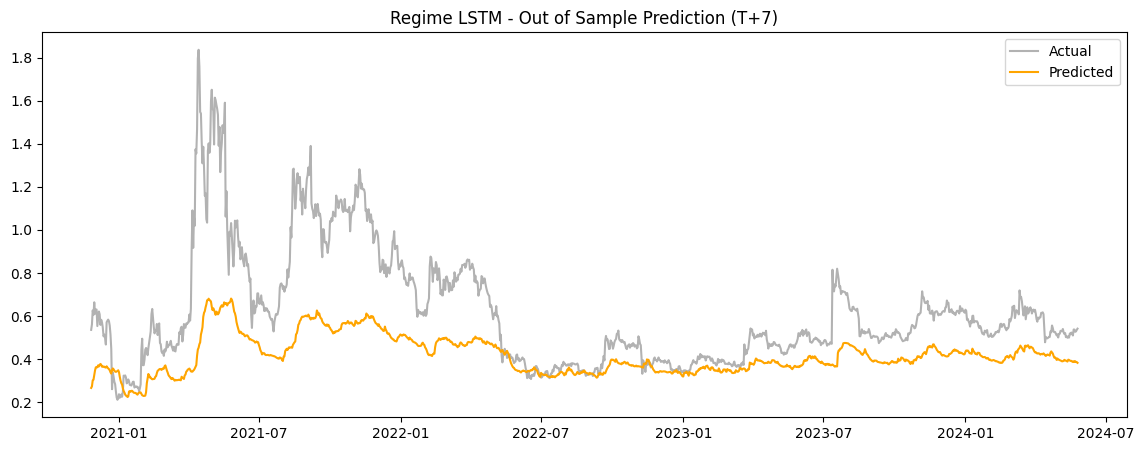

In [12]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# ======================================================
# 0. FIXED SEED FOR REPRODUCIBILITY
# ======================================================
np.random.seed(42)

# ======================================================
# 1. LOAD DATA
# ======================================================
df = pd.read_csv("data2.csv")   # Date, Price, High, Low, Vol
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values("Date").reset_index(drop=True)

EPS = 1e-8

# ======================================================
# 2. FEATURE ENGINEERING
# ======================================================
df['VVR'] = df['Vol'] / (df['High'] - df['Low'] + EPS)
df['VWAP'] = (
    ((df['High'] + df['Low'] + df['Price']) / 3 * df['Vol']).cumsum()
    / (df['Vol'].cumsum() + EPS)
)

for lag in [1, 2, 3, 5, 7]:
    df[f'Lag_{lag}'] = df['Price'].shift(lag)

df['Change'] = df['Price'].pct_change()
df['Volatility'] = df['High'] - df['Low']
df['MA5'] = df['Price'].rolling(5).mean()
df['MA15'] = df['Price'].rolling(15).mean()
df['MA30'] = df['Price'].rolling(30).mean()

# ===== REGIME FEATURE =====
df['vol_z'] = (
    df['Volatility'] - df['Volatility'].rolling(30).mean()
) / (df['Volatility'].rolling(30).std() + EPS)

df['is_spike'] = (df['vol_z'] > 2).astype(int)

df = df.dropna().reset_index(drop=True)

print(f"Rows: {len(df)} | Features: {df.shape[1]-2}")

# ======================================================
# 3. SCALE DATA (MIN-MAX)
# ======================================================
feature_cols = [c for c in df.columns if c not in ['Date', 'Price']]

X_raw = df[feature_cols].values
y_raw = df['Price'].values.reshape(-1, 1)

scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

X_scaled = scaler_X.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw).ravel()

dates = df['Date'].values

# ======================================================
# 4. BUILD SEQUENCES (30 DAYS → T+7)
# ======================================================
LOOKBACK = 30
HORIZON = 7

X_seq, y_seq, y_dates = [], [], []

for i in range(len(X_scaled) - LOOKBACK - HORIZON):
    X_seq.append(X_scaled[i:i + LOOKBACK])
    y_seq.append(y_scaled[i + LOOKBACK + HORIZON - 1])
    y_dates.append(dates[i + LOOKBACK + HORIZON - 1])

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)
y_dates = np.array(y_dates)

print("X:", X_seq.shape, "y:", y_seq.shape)

# ======================================================
# 5. TRAIN / TEST SPLIT (TIME-AWARE)
# ======================================================
# Match Web App: 40% Train, 60% Test
split = int(len(X_seq) * 0.4)

X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]
date_train, date_test = y_dates[:split], y_dates[split:]

print("Train:", X_train.shape, "Test:", X_test.shape)

# ======================================================
# 6. ACTIVATION FUNCTIONS
# ======================================================
def sigmoid(x):
    return 1 / (1 + np.exp(-np.clip(x, -500, 500)))

def dsigmoid(y):
    return y * (1 - y)

def dtanh(y):
    return 1 - y ** 2

# ======================================================
# 7. CUSTOM LSTM CELL (FULL BPTT)
# ======================================================
class CustomLSTM:
    def __init__(self, input_dim, hidden_dim):
        self.hidden_dim = hidden_dim
        # Seed for weights initialization
        np.random.seed(42)

        self.Wf = np.random.randn(input_dim + hidden_dim, hidden_dim) * 0.1
        self.Wi = np.random.randn(input_dim + hidden_dim, hidden_dim) * 0.1
        self.Wc = np.random.randn(input_dim + hidden_dim, hidden_dim) * 0.1
        self.Wo = np.random.randn(input_dim + hidden_dim, hidden_dim) * 0.1

        self.Wy = np.random.randn(hidden_dim, 1) * 0.1

    def forward(self, X):
        h = np.zeros(self.hidden_dim)
        c = np.zeros(self.hidden_dim)
        self.cache = []

        for x in X:
            z = np.concatenate([h, x])

            f = sigmoid(z @ self.Wf)
            i = sigmoid(z @ self.Wi)
            c_hat = np.tanh(z @ self.Wc)
            o = sigmoid(z @ self.Wo)

            c_prev = c
            c = f * c_prev + i * c_hat
            h = o * np.tanh(c)

            self.cache.append((z, f, i, c_hat, o, c, h, c_prev))

        y = h @ self.Wy
        return y.item(), h

    def backward(self, y_true, y_pred, lr=0.001):
        dy = 2 * (y_pred - y_true)

        h_last = self.cache[-1][6]
        self.Wy -= lr * np.outer(h_last, dy)

        dh_next = self.Wy.flatten() * dy
        dc_next = np.zeros(self.hidden_dim)

        for z, f, i, c_hat, o, c, h, c_prev in reversed(self.cache):
            do = dh_next * np.tanh(c) * dsigmoid(o)
            dc = dh_next * o * dtanh(np.tanh(c)) + dc_next
            
            dc_hat = dc * i * dtanh(c_hat)
            di = dc * c_hat * dsigmoid(i)
            df = dc * c_prev * dsigmoid(f)

            self.Wf -= lr * np.outer(z, df)
            self.Wi -= lr * np.outer(z, di)
            self.Wc -= lr * np.outer(z, dc_hat)
            self.Wo -= lr * np.outer(z, do)

            dz = df @ self.Wf.T + di @ self.Wi.T + dc_hat @ self.Wc.T + do @ self.Wo.T
            dh_next = dz[:self.hidden_dim]
            dc_next = f * dc

# ======================================================
# 8. TRAINING LOOP
# ======================================================
model = CustomLSTM(input_dim=X_train.shape[2], hidden_dim=32)
epochs = 70
lr = 0.001

for ep in range(epochs):
    losses = []
    for X_batch, y_batch in zip(X_train, y_train):
        yp, _ = model.forward(X_batch)
        losses.append((yp - y_batch) ** 2)
        model.backward(y_batch, yp, lr)
    
    if (ep + 1) % 10 == 0 or ep == 0:
        print(f"Epoch {ep+1}/{epochs} | Loss: {np.mean(losses):.6f}")

# ======================================================
# 9. EVALUATION
# ======================================================
preds_scaled = []
for X_batch in X_test:
    yp, _ = model.forward(X_batch)
    preds_scaled.append(yp)

y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()
preds_inv = scaler_y.inverse_transform(np.array(preds_scaled).reshape(-1, 1)).ravel()

mse = mean_squared_error(y_test_inv, preds_inv)
print(f"Test MSE: {mse}")

plt.figure(figsize=(14, 5))
plt.plot(date_test, y_test_inv, label="Actual", color='gray', alpha=0.6)
plt.plot(date_test, preds_inv, label="Predicted", color='orange')
plt.title("Regime LSTM - Out of Sample Prediction (T+7)")
plt.legend()
plt.show()